In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device
model_name = "./model"


device(type='cuda')

In [3]:

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.sep_token
tokenizer.sep_token_id

sent = "There is a ball </s> The cat ate it"
tokenizer.special_tokens_map
tokenizer.encode_plus(sent, add_special_tokens=True,)
tokenizer.batch_encode_plus([sent, sent], add_special_tokens=True,)

from fasttext import tokenize
tokenize(sent)



'</s>'

2

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

{'input_ids': [0, 345, 16, 10, 1011, 2, 20, 4758, 14964, 24, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

{'input_ids': [[0, 345, 16, 10, 1011, 2, 20, 4758, 14964, 24, 2], [0, 345, 16, 10, 1011, 2, 20, 4758, 14964, 24, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

['There', 'is', 'a', 'ball', '</s>', 'The', 'cat', 'ate', 'it']

In [4]:
choice_probas = {
    "keyboard": 0.1,
    "char_substitute": 0.0,
    "char_insert": 0.1,
    "char_swap": 0.0,
    "ocr": 0.0,
    "char_delete": 0.1,
    "fasttext": 0.0,
    "glove_twitter": 0.0,
    "glove_wiki": 0.0,
    "word2vec": 0.0,
    "split": 0.2,
    "stopword_insert": 0.2,
    "word_join": 0.0,
    "word_cutout": 0.2,
    "text_rotate": 0.0,
    "sentence_shuffle": 0.5,
    "one_third_cut": 0.5,
    "half_cut": 0.0
}

preprocess_text = TextAugment([0.0, 0.5, 0.5],
                                choice_probas,
                                fasttext_file="wiki-news-300d-1M-subword.bin")


preprocess_text = np.vectorize(preprocess_text)

texts = pd.read_csv("text.csv", header=None)[0].values


# ImageAugment([0.2, 0.5, 0.3])

In [5]:
def get_tx_tx(texts):
    sep_token = f" {tokenizer.sep_token} "
    tx_tx = [i + sep_token + j for i, j in zip(texts, texts)]
    for _ in range(1):
        ttx_ttx_1 = [i + sep_token + j for i, j in zip(preprocess_text(texts), texts)]
        tx_tx = tx_tx + ttx_ttx_1
    return tx_tx

tx_tx = get_tx_tx(texts)
len(tx_tx)
np.random.permutation(tx_tx)[:5]

def get_tx_ty(texts):
    sep_token = f" {tokenizer.sep_token} "
    tx_ty = []
    for _ in range(5):
        tx_ty_org = [i + sep_token + j for i, j in zip(texts, np.random.permutation(texts))]
        ttx_ty_1 = [i + sep_token + j for i, j in zip(np.random.permutation(preprocess_text(texts)), texts)]
        tx_ty = tx_ty + tx_ty_org + ttx_ty_1
    return tx_ty

tx_ty = get_tx_ty(texts)
len(tx_ty)
np.random.permutation(tx_ty)[:5]


20000

array(["it's ma'am!! i can't give you a ma'am, but i can give </s> it's ma'am!! i can't give you a ma'am, but i can give you a green eggs and haaaaaammmmmmm!",
       "i didn't buy a colour tv to watch naggers on it </s> i didn't buy a colour tv to watch naggers on it",
       "if he wears numb er one he ' s most the fastes on the team </s> if he wears number one he's most likely the fastes on the team",
       'when her head game so strong she suck a chromosome </s> when her head game so strong she suck a chromosome right out of you',
       "there's no better time to combine out efftorts than now! blacks whites team - together everyone achieves more </s> there's no better time to combine out efftorts than now! blacks whites team - together everyone achieves more"],
      dtype='<U872')

100000

array(['there are 33 genders man, woman, and 31 types of </s> sharing and caring',
       "who's gonna make the sandwiches? what do we do with all these sandwiches? </s> the evolution of man",
       'when muslims attack be prepared to fight back </s> 666 6 protons 6 neutrons 6 elektrons 666 is the chemical make up of black people! not any beast... unlearn their bullshit !',
       "so cohen has a history of intentional dishonesty from lying to congress, lying to the\x81 irs, lying about his wife's 's birth. lying to banks and he even took millions as an insider consultant without informing trump but dems trust his testimony to be truthful. lol! </s> i don't know how it happened, one moment i was on my bike next thing i knew, i woke up in a hospital",
       'answer the phone . no signal out here! haha </s> men days in the days men today'],
      dtype='<U658')

In [6]:
label = [1] * len(tx_tx) + [0] * len(tx_ty)
text = tx_tx + tx_ty
img = [""] * len(text)

assert len(label) == len(text)

df = pd.DataFrame({"label": label, "img": img, "text": text})
df = df.sample(frac=1.0)
df["id"] = np.arange(len(df))

df.head()
df.shape

data = dict(train=df,
            test=df,
            dev=df.sample(frac=0.1),
            metadata=dict(cache_images=False,
                          use_images=False,
                          dev=False,
                          keep_original_text=False,
                          keep_original_image=False,
                          keep_processed_image=False,
                          keep_torchvision_image=False,
                          train_text_transform=None,
                          train_image_transform=None,
                          train_torchvision_image_transform=None,
                          test_torchvision_image_transform=None,
                          test_text_transform=None,
                          test_image_transform=None,
                          augmented_data=False))


,label,img,text,id
33248,0,,rights of husband you never give hasn your wif...,0
66511,0,,a muslim in congress wants to get rid of homel...,1
103257,0,,a monkey wearing makeup and a dress does not m...,2
54838,0,,back in my day blowin a tranny was car rouble ...,3
85751,0,,creeps into your childs room empties his sack ...,4


(120000, 4)

In [15]:
data["train"] = df.sample(frac=1.0)

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [21]:
sgd = torch.optim.SGD
sgd_params = dict(lr=3e-4, momentum=0.9, dampening=0, weight_decay=1e-4, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-5, weight_decay=1e-2)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [22]:
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_cosine_schedule_with_warmup()
# scheduler_init_fn = None
reg_sched = get_regularizer_scheduler()
augmentation_weights = {"None": 1.0}



In [26]:
def save(model, tokenizer, output_dir):
    import os
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)


# Augmented/Masked Text same as Original Text - RMSE

In [12]:

from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel
class BertVectorizer(torch.nn.Module):
    def __init__(self, model, sequence_length, pooled_multiplier):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model)
        self.sequence_length = sequence_length
        self.pooled_multiplier = pooled_multiplier
        
    def forward(self, texts):
        tokenizer = self.tokenizer
        n_tokens_in = self.sequence_length
        converted_texts = tokenizer.batch_encode_plus(texts, add_special_tokens=True, pad_to_max_length=True, max_length=n_tokens_in, truncation=True)
        input_ids, attention_mask = converted_texts["input_ids"], converted_texts["attention_mask"]
        input_ids, attention_mask = torch.tensor(input_ids).to(get_device()), torch.tensor(attention_mask).to(get_device())
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs[0]
        pooled_output = outputs[1].unsqueeze(1)
        pooled_output = pooled_output * self.pooled_multiplier
        output = torch.cat((pooled_output, last_hidden_states), 1)
        return output
        
        



In [13]:
from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])
dataset[2]


"happy pride month let's go beat up lesbians"

Autocast =  True Epochs =  5 Examples = 10000 Batch Size =  384
Training Samples =  10000 Weighted Sampling =  False Num Batches =  27 Accumulation steps =  1



Epoch =  1 Loss = 0.071251 LR = 0.00000001



Epoch =  2 Loss = 0.070363 LR = 0.00000001



Epoch =  3 Loss = 0.068038 LR = 0.00000001



Epoch =  4 Loss = 0.067179 LR = 0.00000000



Epoch =  5 Loss = 0.067461 LR = 0.00000000



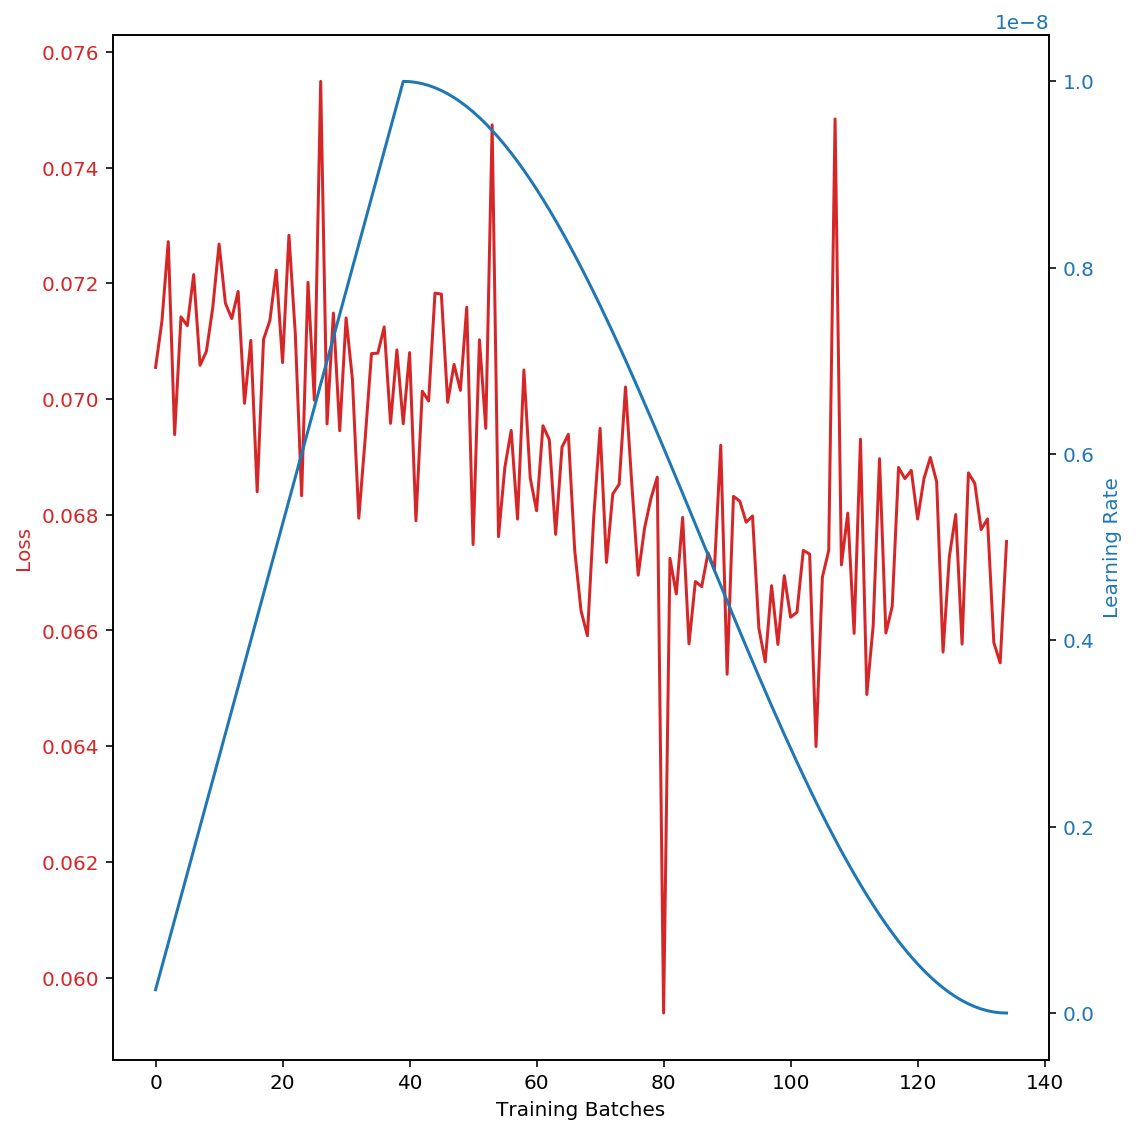

In [14]:
epochs = 5
batch_size = 384
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(BertVectorizer,
                         dict(sequence_length=88,
                              pooled_multiplier=10,
                              model=model_name),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

model, optim = model_fn()


def augment_method(texts):
    mask_proba = 0.15
    texts = [random_word_mask(t, model.tokenizer, mask_proba) for t in texts]
    return preprocess_text(texts)


_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 accumulation_steps=1,
                                 plot=True)

# 0.06687


In [15]:
save(model.model, model.tokenizer, output_dir="./model-augsim")


# NSP Style Pretraining

In [27]:
optimizer = sgd
optimizer_params = sgd_params
model_name = "./model-augsim"


In [28]:

epochs = 1
batch_size = 384
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=1,
                              n_decoders=0,
                              n_tokens_in=88*2,
                              n_tokens_out=4,
                              featurizer="transformer",
                              model=model_name,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709




Autocast =  True Epochs =  1 Divisor = 1 Examples = 96000 Batch Size =  384
Training Samples =  96000 Weighted Sampling =  False Num Batches =  250 Accumulation steps =  1



Epoch =  1 Loss = 0.104893 LR = 0.00000000



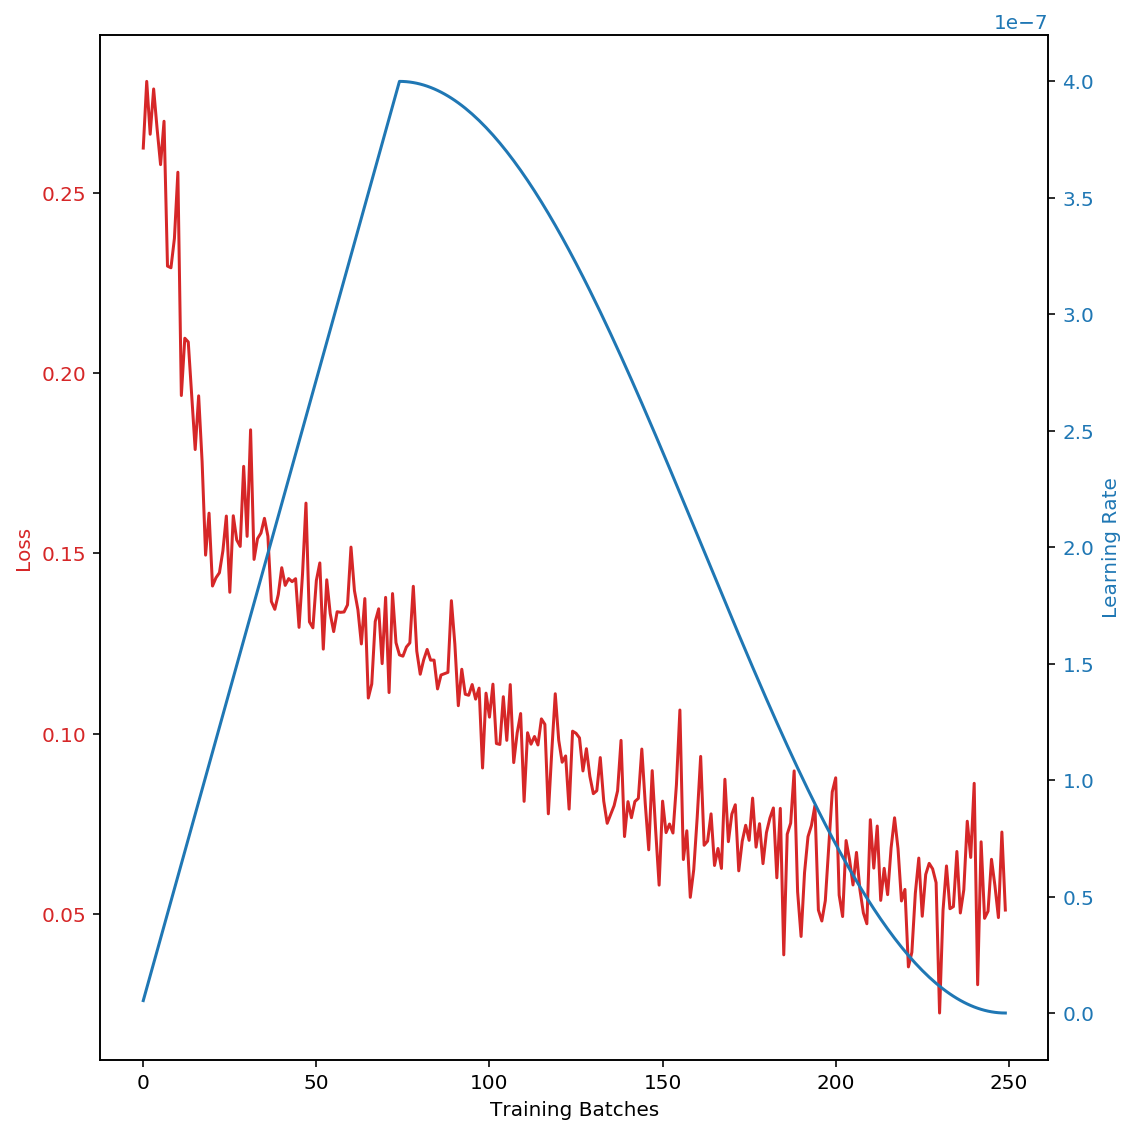

train   val
mean_or_std metric               
mean        map       0.779 0.776
            accuracy  0.911 0.911
            auc       0.930 0.929
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                              val                       
    precision recall    f1   supoort precision recall    f1   supoort
neg     0.927  0.969 0.948 80000.000     0.926  0.970 0.948 20000.000
pos     0.798  0.621 0.698 16000.000     0.804  0.613 0.695  4000.000

In [20]:

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    accumulation_steps=1,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[5, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy=None)
r2, p2 = results, prfs
results
prfs

Autocast =  True Epochs =  1 Divisor = 1 Examples = 96000 Batch Size =  384
Training Samples =  96000 Weighted Sampling =  False Num Batches =  250 Accumulation steps =  1



Epoch =  1 Loss = 0.119639 LR = 0.00000000



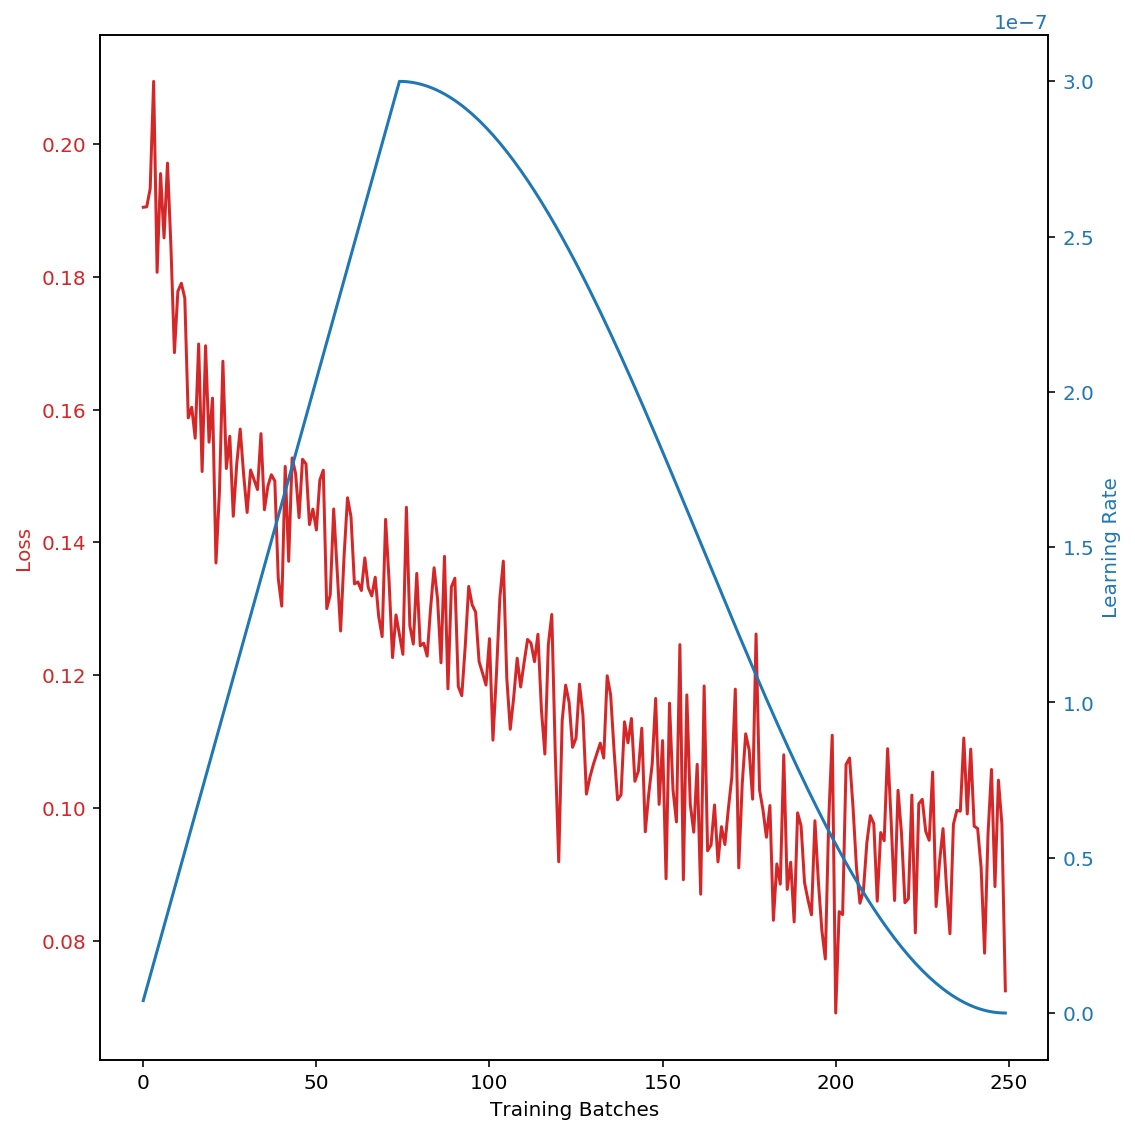

In [29]:
data["train"] = df.sample(frac=0.8)

dataset = convert_dataframe_to_dataset(data["train"], data["metadata"], True)
model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)


In [30]:
save(model.model, model.tokenizer, output_dir="./model-nsp")